In [1]:
! pwd

/home/work/notebooks


In [2]:
##########################Load Libraries  ####################################
import os
import pickle
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from fastprogress import master_bar, progress_bar
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.autograd import Variable
from tqdm.notebook import tqdm_notebook as tqdm

%matplotlib inline

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
pd.set_option("max_columns", 50)

DEVICE = "cpu"

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 0

In [4]:
T = 4000
W_feat = 20
W_target = 1
W = W_feat + W_target
T_train = int(0.8 * T)
T_test = T - T_train

In [5]:
seed_everything(SEED)

ts = np.arange(T)
fs = [0.04, 0.023]

xs1 = np.sin(fs[0] * ts)
xs1 += np.random.normal(loc=0.0, scale=0.1, size=ts.shape)

xs2 = np.sin(fs[1] * ts)
xs2 += np.random.normal(loc=0.0, scale=0.1, size=ts.shape)

xs3 = np.zeros(shape=ts.shape)
alp = 0.1
xs3[200::400] = 1
xs4 = xs3.copy()
for i in range(1, T):
    xs4[i] = alp * xs3[i] + (1 - alp) * xs4[i - 1]
xs4 /= alp
xs4 += np.random.normal(loc=0.0, scale=0.1, size=ts.shape)

ys1 = xs1 + xs2 + xs4
ys1 += np.random.normal(loc=0.0, scale=0.1, size=ts.shape)

ys2 = np.exp(ys1).reshape(ts.shape) / 6

idx = 0 * np.ones(ts.shape)

df = pd.DataFrame(
    np.array([idx, ts, xs1, xs2, xs3, ys1, ys2]).T,
    columns=["id", "time", "xs1", "xs2", "xs3", "ys1", "ys2"],
)
df["id"] = df["id"].astype(int)
df["time"] = df["time"].astype(int)

df_train = df[df["time"] < T_train].copy()
df_test = df[df["time"] >= T_train].copy()


with open("../data/raw/data.pkl", mode="wb") as f:
    pickle.dump(df, f)

with open("../data/raw/data_train.pkl", mode="wb") as f:
    pickle.dump(df_train, f)

with open("../data/raw/data_test.pkl", mode="wb") as f:
    pickle.dump(df_test, f)

print(df.shape)
print(df_train.shape)
print(df_test.shape)
df.head()

(4000, 7)
(3200, 7)
(800, 7)


,id,time,xs1,xs2,xs3,ys1,ys2
0,0,0,0.176405,0.061335,0.0,0.432075,0.256742
1,0,1,0.080005,0.207368,0.0,0.355673,0.237857
2,0,2,0.177788,0.073093,0.0,0.225820,0.208892
3,0,3,0.343802,0.182590,0.0,0.653514,0.320381
4,0,4,0.346074,-0.081963,0.0,0.171835,0.197914


In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))

df_std = df.copy()

df_std.loc[:T_train, "xs1":] = scaler.fit_transform(df.loc[:T_train, "xs1":].values)
df_std.loc[T_train:, "xs1":] = scaler.transform(df.loc[T_train:, "xs1":].values)
df_std.head()

,id,time,xs1,xs2,xs3,ys1,ys2
0,0,0,0.149538,0.057045,-1.0,0.149142,-0.759291
1,0,1,0.074714,0.172206,-1.0,0.117607,-0.778162
2,0,2,0.150611,0.066317,-1.0,0.064010,-0.807107
3,0,3,0.279468,0.152666,-1.0,0.240541,-0.695697
4,0,4,0.281231,-0.055960,-1.0,0.041727,-0.818077


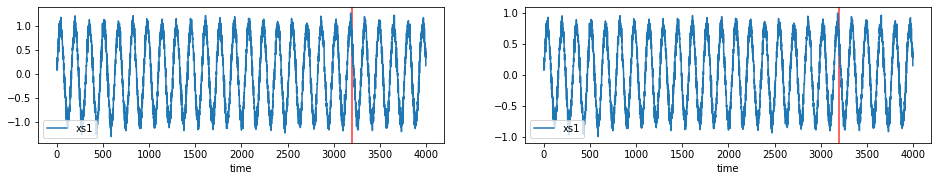

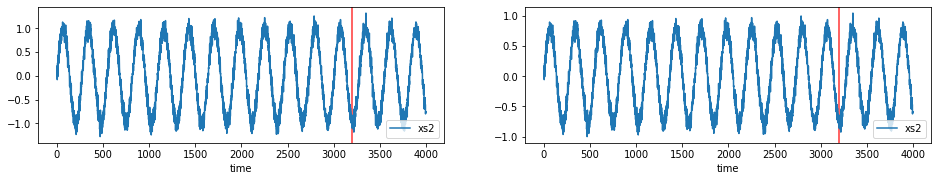

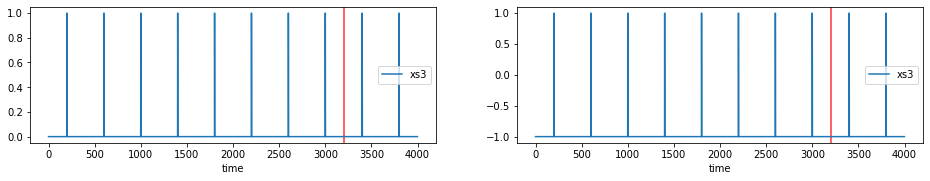

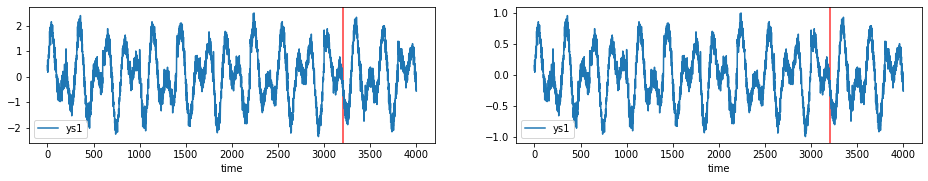

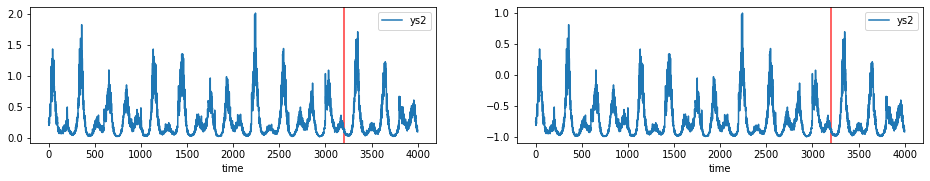

In [7]:
for col in df.loc[:, "xs1":].columns:
    fig, axs = plt.subplots(1, 2, figsize=(16, 2.5))

    df.plot(x="time", y=col, ax=axs[0])
    ylim = axs[0].get_ylim()
    axs[0].vlines(x=T_train, ymin=ylim[0], ymax=ylim[1], color="r", alpha=0.8)
    axs[0].set_ylim(ylim)

    df_std.plot(x="time", y=col, ax=axs[1])
    ylim = axs[1].get_ylim()
    axs[1].vlines(x=T_train, ymin=ylim[0], ymax=ylim[1], color="r", alpha=0.8)
    axs[1].set_ylim(ylim)

    plt.show()

In [8]:
from __future__ import division, print_function

import os
# Ignore warnings
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

warnings.filterwarnings("ignore")

In [9]:
class TimeSeriesDataset(Dataset):
    """Time Series dataset."""

    def __init__(
        self,
        data_dir="../data/raw",
        W_feat=W_feat,
        W_target=W_target,
        train=True,
        transform=None,
    ):

        self.data_dir = data_dir
        if train:
            file_path = os.path.join(self.data_dir, "data_train.pkl")
        else:
            file_path = os.path.join(self.data_dir, "data_test.pkl")

        with open(file_path, mode="rb") as f:
            df = pickle.load(f)

        self.data = df.drop(columns=["id", "time"], axis=1)

        self.W_feat = W_feat
        self.W_target = W_target
        self.W = self.W_feat + self.W_target

        self.cols_feat = df.columns[df.columns.str.startswith("xs")].to_list()
        self.cols_target = df.columns[df.columns.str.startswith("ys")].to_list()

        self.transform = transform

    def __len__(self):
        return len(self.data) - self.W

    def __getitem__(self, idx):
        data = self.data.iloc[idx : idx + self.W, :]
        feature = data.iloc[: self.W_feat, :][self.cols_feat].values
        target = data.iloc[self.W_feat :, :][self.cols_target].values
        sample = {"feature": feature, "target": target}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [10]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        feature, target = sample["feature"], sample["target"]

        return {
            "feature": Variable(torch.Tensor(feature)),
            "target": Variable(torch.Tensor(target)),
        }

In [11]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.25,
        )

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(
            torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
        )
        c_0 = Variable(
            torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
        )

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)

        return out

In [12]:
dataset_train = TimeSeriesDataset(
    data_dir="../data/raw",
    W_feat=W_feat,
    W_target=W_target,
    train=True,
    transform=transforms.Compose([ToTensor()]),
)

dataset_test = TimeSeriesDataset(
    data_dir="../data/raw",
    W_feat=W_feat,
    W_target=W_target,
    train=False,
    transform=transforms.Compose([ToTensor()]),
)

In [13]:
batch_size = 256

# Create data loaders.
# dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
# dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

print("train dataset :", len(dataloader_train.dataset))
print("test  dataset :", len(dataloader_test.dataset))

for Xy in dataloader_train:
    print("Shape of X [N, T, F]: ", Xy["feature"].shape)
    print("Shape of y: ", Xy["target"].shape)
    break

for Xy in dataloader_test:
    print("Shape of X [N, T, F]: ", Xy["feature"].shape)
    print("Shape of y: ", Xy["target"].shape)
    break

train dataset : 3179
test  dataset : 779
Shape of X [N, T, F]:  torch.Size([256, 20, 3])
Shape of y:  torch.Size([256, 1, 2])
Shape of X [N, T, F]:  torch.Size([256, 20, 3])
Shape of y:  torch.Size([256, 1, 2])


In [14]:
seed_everything(SEED)

#####  Parameters  ######################
num_epochs = 200
learning_rate = 1e-2
input_size = 3
hidden_size = 32
num_layers = 1
num_classes = 2

#####Init the Model #######################
model = LSTM(num_classes, input_size, hidden_size, num_layers)
model = model.to(DEVICE)

loss_fn = nn.MSELoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=500, factor=0.5, min_lr=1e-7, eps=1e-08
)

In [15]:
import glob
# %load_ext tensorboard
# %tensorboard --logdir logs --bind_all

from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here

path_dir = "runs/exp_0000/"
os.makedirs(path_dir, exist_ok=True)
for path in glob.glob("runs/*"):
    if not os.path.isdir(path):
        os.remove(path)

writer = SummaryWriter(path_dir)


In [16]:
def train(dataloader, model, loss_fn, optimizer, num_curr, device=DEVICE):
    size = len(dataloader.dataset)
    model.train()
    for batch, Xy in enumerate(dataloader):
        X, y = Xy["feature"].to(device), Xy["target"].to(device)

        # Compute prediction error
        #         model.train()
        pred = model(X)
        assert (
            pred.squeeze().data.numpy().shape == y.squeeze().data.numpy().shape
        ), "wtf"
        loss = loss_fn(pred.squeeze(), y.squeeze())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #         if batch == 12:
        print(f"{num_curr + batch} loss: {loss.item():>7f}")

        # ...log the running loss
        writer.add_scalar("training loss", loss.item(), num_curr + batch)


def test(dataloader, model, loss_fn, device=DEVICE):
    model.eval()
    with torch.no_grad():
        for batch, Xy in enumerate(dataloader):
            X, y = Xy["feature"].to(device), Xy["target"].to(device)
            pred = model(X)
            val_loss = loss_fn(pred, y)

In [17]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    num_curr = t * np.ceil(len(dataloader_train.dataset) / batch_size).astype(int)
    train(dataloader_train, model, loss_fn, optimizer, num_curr)
#     test(dataloader_test, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
0 loss: 0.570796
1 loss: 0.733659
2 loss: 0.607389
3 loss: 0.240632
4 loss: 0.513236
5 loss: 0.496425
6 loss: 0.130654
7 loss: 0.213744
8 loss: 0.196299
9 loss: 0.147856
10 loss: 0.237399
11 loss: 0.202749
12 loss: 0.046949
Epoch 2
-------------------------------
13 loss: 0.068770
14 loss: 0.125791
15 loss: 0.125021
16 loss: 0.055483
17 loss: 0.129968
18 loss: 0.155657
19 loss: 0.040264
20 loss: 0.058499
21 loss: 0.107502
22 loss: 0.051158
23 loss: 0.058244
24 loss: 0.077009
25 loss: 0.029394
Epoch 3
-------------------------------
26 loss: 0.056892
27 loss: 0.061783
28 loss: 0.046538
29 loss: 0.034172
30 loss: 0.047288
31 loss: 0.060478
32 loss: 0.031432
33 loss: 0.036711
34 loss: 0.073874
35 loss: 0.035318
36 loss: 0.034788
37 loss: 0.048963
38 loss: 0.023935
Epoch 4
-------------------------------
39 loss: 0.039534
40 loss: 0.041586
41 loss: 0.044254
42 loss: 0.033030
43 loss: 0.038183
44 loss: 0.048555
45 loss: 0.031674
46 loss: 0.028470
47 l

In [18]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


(0.0, 800.0)

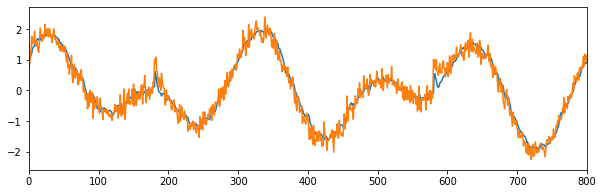

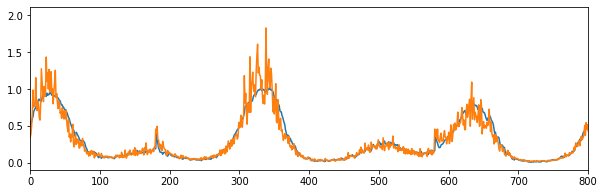

In [19]:
dataloader_new = DataLoader(dataset_train, batch_size=T_train, shuffle=False)

model.eval()
with torch.no_grad():
    for _, Xy in enumerate(dataloader_new):
        X, y = Xy["feature"].to(DEVICE), Xy["target"].to(DEVICE)
        pred = model(X)
        data_predict = pred.cpu().data.numpy()
        data_true = y.data.numpy().squeeze()

# z = next(iter(dataloader_new))
# plt.plot(z["feature"].numpy()[:, 0, 0])
# plt.plot(z["feature"].numpy()[:, 0, 1])
# plt.plot(z["feature"].numpy()[:, 0, 2])
plt.figure(figsize=(10, 3))
plt.plot(data_predict[:, 0])
plt.plot(data_true[:, 0])
plt.xlim(0, 800)

plt.figure(figsize=(10, 3))
plt.plot(data_predict[:, 1])
plt.plot(data_true[:, 1])
plt.xlim(0, 800)

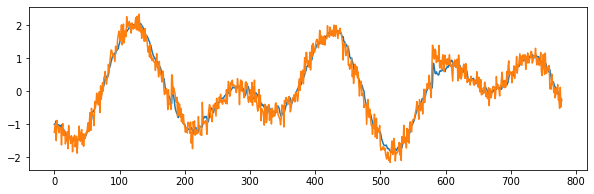

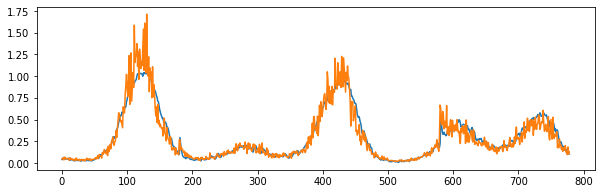

In [20]:
dataloader_new = DataLoader(dataset_test, batch_size=T_test, shuffle=False)

model.eval()
with torch.no_grad():
    for _, Xy in enumerate(dataloader_new):
        X, y = Xy["feature"].to(DEVICE), Xy["target"].to(DEVICE)
        pred = model(X)
        data_predict = pred.cpu().data.numpy()
        data_true = y.data.numpy().squeeze()

# z = next(iter(dataloader_new))
# plt.plot(z["feature"].numpy()[:, 0, 0])
# plt.plot(z["feature"].numpy()[:, 0, 1])
# plt.plot(z["feature"].numpy()[:, 0, 2])
plt.figure(figsize=(10, 3))
plt.plot(data_predict[:, 0])
plt.plot(data_true[:, 0])
# plt.xlim(0, 1000)

plt.figure(figsize=(10, 3))
plt.plot(data_predict[:, 1])
plt.plot(data_true[:, 1])
# plt.xlim(0, 1000)

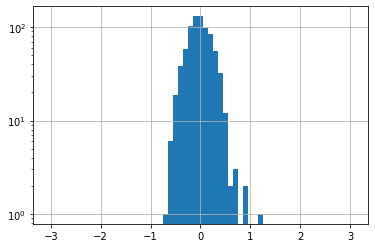

In [21]:
tmp = data_true[:, 0] - data_predict[:, 0]
pd.Series(tmp).hist(bins=np.arange(-3.05, 3.15, 0.1))
plt.yscale("log")

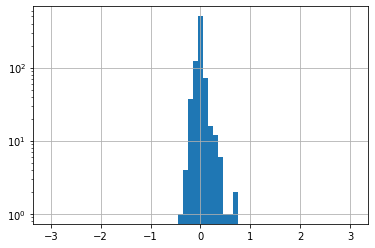

In [22]:
tmp = data_true[:, 1] - data_predict[:, 1]
pd.Series(tmp).hist(bins=np.arange(-3.05, 3.15, 0.1))
plt.yscale("log")